In [1]:
#IMPORTS
import warnings
import pandas as pd
import h5py
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import os
import scipy.signal as sgn
import matplotlib.pyplot as plt
import random
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import neurokit2 as nk
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import silhouette_score
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import HDBSCAN
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, BatchNormalization, ELU, Input
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
sys.path.append('../Pre-processing')  
from filters import ecg_filtrado

/home/grad/si/24/guilherme.evangelista/anaconda3/envs/condaclustering/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-08 16:41:02.940433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 16:41:02.951298: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 16:41:02.954612: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 16:41:02.963644: I tensorflow/core/platform/cpu_fe

In [2]:
import pandas as pd
import numpy as np

#CARREGAR OS DADOS
caminho_arquivo = "../Database/exams.csv"
dados = pd.read_csv(caminho_arquivo)
arquivos_usados = ["exams_part2.hdf5", "exams_part3.hdf5"]

ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == False) & 
                                (dados.iloc[:, 5] == False) & 
                                (dados.iloc[:, 6] == False) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == False) & 
                                (dados.iloc[:, 13] == True)]

ecg_doente_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == False) & 
                                (dados.iloc[:, 5] == False) & 
                                (dados.iloc[:, 6] == False) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == False) & 
                                (dados.iloc[:, 13] == True)]

print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

caminho_interferencias = "../Database/resultados_interferencia.csv"
interferencias = pd.read_csv(caminho_interferencias)
interferencias_ids = interferencias['exam_id'].tolist()

ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == False) & 
                                (dados.iloc[:, 5] == False) & 
                                (dados.iloc[:, 6] == False) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == False) & 
                                (dados.iloc[:, 13] == True)]

ecg_doente_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == False) & 
                                (dados.iloc[:, 5] == False) & 
                                (dados.iloc[:, 6] == False) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == False) & 
                                (dados.iloc[:, 13] == True)]

print("Tirando Interferência:")
print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

ecg_doente_id = dados.iloc[ecg_doente_linhas, 0].tolist()
ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()

#ecg_doente = ecg_doente_id[]
ecg_normal = ecg_normal_id[:50]

ids_ecgs= ecg_doente_id[:50] + ecg_normal
print("Número de ecgs pra clusterizar:", len(ids_ecgs))

y_doente = [1] * len(ecg_doente_id[:50])  # Rótulo 1 para os doentes
y_normal = [0] * len(ecg_normal[:50])     # Rótulo 0 para os normais

# Concatena os labels
Y = y_doente + y_normal

print("Número de ecgs pra clusterizar:", len(Y))



import h5py
#X

arquivos_hdf5 = ["../Database/filtered_exams_2_3.hdf5"]

def get_ecg_data(file_path, exam_id):
    with h5py.File(file_path, 'r') as f:
        # Obter os IDs dos exames
        exam_ids = np.array(f['exam_id'])

        # Encontrar o índice correspondente ao exam_id de interesse
        exam_index = np.where(exam_ids == exam_id)[0]

        if len(exam_index) == 0:
            raise ValueError("Exam ID não encontrado.")
        else:
            exam_index = exam_index[0]
            # Acessar os tracings de ECG correspondentes ao exam_index
            exam_tracings = f['tracings'][exam_index]
            # Preencher tracings nulos com epsilon
            return exam_tracings

exam_ids_to_cluster = ids_ecgs  # Substitua pelos IDs reais dos exames

# Lista para armazenar todos os tracings de ECG
all_tracings = []

# Obter os tracings de ECG para cada exam_id e armazenar na lista
for exam_id in exam_ids_to_cluster:
    found = False  # Sinalizador para verificar se o exame foi encontrado em algum arquivo
    for arquivo in arquivos_hdf5:
        try:
            tracings = get_ecg_data(arquivo, exam_id)
            if tracings is not None:
                tracing_transposto = np.array(tracings).T
                all_tracings.append(tracing_transposto)
                found = True  # Sinalizador para indicar que o exame foi encontrado
                break  # Se encontrou, não precisa continuar buscando nos outros arquivos
        except ValueError as e:
            i = 0
        except Exception as e:
            i = 0
    
    if not found:
        print(f"Erro: exame ID {exam_id} não encontrado em nenhum dos arquivos.")

# Verifique o tamanho da lista all_tracings para garantir que os dados foram coletados corretamente
print("Número de ecgs que eram pra ser processados:", len(ids_ecgs))
print(f"Número total de traçados processados: {len(all_tracings)}")

# X será um array com um único array dentro, contendo todos os números do tracings.T
X = np.array(all_tracings)



Número de linhas ecg_normal_linhas: 15333
Número de linhas ecg_doente_linhas: 15333
Tirando Interferência:
Número de linhas ecg_normal_linhas: 14865
Número de linhas ecg_doente_linhas: 14865
Número de ecgs pra clusterizar: 100
Número de ecgs pra clusterizar: 100
Número de ecgs que eram pra ser processados: 100
Número total de traçados processados: 100


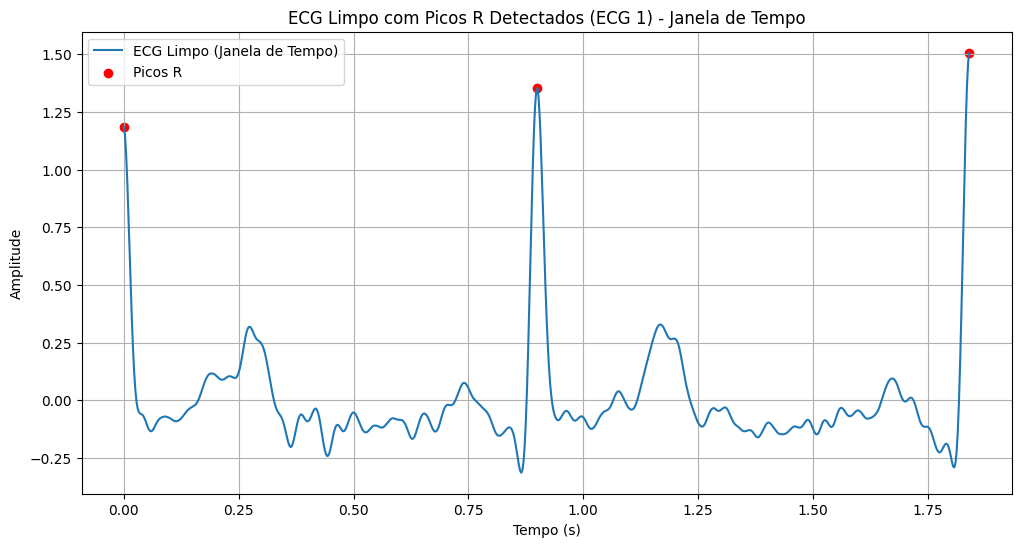

In [3]:
# Função para processar ECGs e armazenar R peaks
def processar_ecgs_multileads(ecgs):
    """
    Processa um vetor de ECGs com múltiplas derivações. Para cada ECG, limpa o sinal na primeira derivação,
    detecta os picos R e faz o corte sincronizado em todas as derivações.

    Parâmetros:
    ecgs: array 3D (n_ecgs x n_leads x n_samples) - Matriz contendo vários ECGs de múltiplas derivações

    Retorno:
    novo_ecgs: lista de arrays - Lista de ECGs processados
    r_peaks_list: lista de arrays - Lista contendo os índices dos R peaks relativos para cada ECG
    """
    n_ecgs, n_leads, n_samples = ecgs.shape
    novo_ecgs = []        # Lista para armazenar os novos ECGs processados
    r_peaks_list = []     # Lista para armazenar os R peaks de cada ECG

    for i in range(n_ecgs):
        # Para cada ECG, obter as derivações
        ecg = ecgs[i]

        # Limpar o sinal da primeira derivação
        first_lead = ecg[0]
        sampling_rate = 400
        ecg_cleaned = nk.ecg_clean(first_lead, sampling_rate=sampling_rate)

        # Detectar picos R no sinal limpo
        peaks = nk.ecg_findpeaks(ecg_cleaned, sampling_rate=sampling_rate)

        # Extrair os índices dos picos R da primeira derivação
        r_peaks = peaks['ECG_R_Peaks']

        # Verificar se há picos suficientes
        if len(r_peaks) < 3:
            print(f"ECG {i + 1}: Não foram detectados picos R suficientes para processamento.")
            novo_ecgs.append(ecg)  # Adiciona o ECG original sem cortes
            r_peaks_list.append([])  # Adiciona uma lista vazia para R peaks
            continue

        # Calcular as distâncias entre os picos consecutivos
        distancias = np.diff(r_peaks)

        # Calcular a mediana das distâncias
        mediana = np.median(distancias)

        # Encontrar o índice do pico cuja distância está mais próxima da mediana
        indice_prox_mediana = np.argmin(np.abs(distancias - mediana))

        # Selecionar os três picos consecutivos
        if indice_prox_mediana + 3 > len(r_peaks):
            # Se não houver picos suficientes, seleciona os últimos três
            novo_ecg_peaks = r_peaks[-3:]
        else:
            novo_ecg_peaks = r_peaks[indice_prox_mediana:indice_prox_mediana + 3]

        # Garantir que temos pelo menos dois pontos para cortar
        if len(novo_ecg_peaks) < 2:
            print(f"ECG {i + 1}: Não foi possível selecionar picos R suficientes para corte.")
            novo_ecgs.append(ecg)  # Adiciona o ECG original sem cortes
            r_peaks_list.append([])  # Adiciona uma lista vazia para R peaks
            continue

        # Definir início e fim da janela
        start = novo_ecg_peaks[0]
        # Ajuste do fim para incluir o último pico sem exceder o número de amostras
        end = novo_ecg_peaks[-1] + 1 if (novo_ecg_peaks[-1] + 1) <= n_samples else novo_ecg_peaks[-1]

        # Criar um novo vetor de ECG para todas as derivações a partir desses picos
        novo_ecg_segmentado = ecg[:, start:end]

        # Substituir ou remover valores NaN
        novo_ecg_segmentado = np.nan_to_num(novo_ecg_segmentado, nan=0.0)

        # Ajustar os R peaks para a janela segmentada (índices relativos)
        r_peaks_window = novo_ecg_peaks - start
        # Garantir que os índices estão dentro dos limites
        r_peaks_window = r_peaks_window[r_peaks_window < (end - start)]

        # Adicionar o novo ECG processado à lista (com diferentes tamanhos)
        novo_ecgs.append(novo_ecg_segmentado)

        # Adicionar os R peaks relativos à lista
        r_peaks_list.append(r_peaks_window)

        # Plotar o primeiro ECG como exemplo
        if i == 0:  # Plota apenas o primeiro ECG processado
            time_window = np.arange(end - start) / sampling_rate  # Tempo em segundos
            plt.figure(figsize=(12, 6))
            plt.plot(time_window, ecg_cleaned[start:end], label="ECG Limpo (Janela de Tempo)")
            # Ajustar os índices dos picos R para a janela
            plt.scatter(time_window[r_peaks_window], ecg_cleaned[novo_ecg_peaks], color='red', label="Picos R")
            plt.title(f"ECG Limpo com Picos R Detectados (ECG {i + 1}) - Janela de Tempo")
            plt.xlabel("Tempo (s)")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.grid()
            plt.show()

    return novo_ecgs, r_peaks_list

# Processar os ECGs
novo_ecg, r_peaks_list = processar_ecgs_multileads(X)

In [4]:
# Função para inverter ECGs e ajustar os R peaks
def inverter_ecg_e_rpeaks(novo_ecgs, r_peaks_list):
    invertido_ecgs = []
    invertido_r_peaks_list = []

    for ecg, r_peaks in zip(novo_ecgs, r_peaks_list):
        # Inverter o sinal do ECG
        ecg_invertido = -ecg
        invertido_ecgs.append(ecg_invertido)

        # Os R peaks permanecem nas mesmas posições relativas
        invertido_r_peaks_list.append(r_peaks)

    return invertido_ecgs, invertido_r_peaks_list


In [5]:
# Função para plotar ECG invertido com R peaks
def plotar_ecg_invertido_com_rpeaks(ecg_invertido, r_peaks_invertidos, sampling_rate=400, ecg_index=0):
    # Seleciona a primeira derivação para plotagem
    first_lead_invertido = ecg_invertido[0]

    # Cria o vetor de tempo
    n_samples = first_lead_invertido.shape[0]
    time = np.arange(n_samples) / sampling_rate  # Tempo em segundos

    # Verificar se há R peaks para plotar
    if len(r_peaks_invertidos) == 0:
        print(f"ECG {ecg_index + 1}: Nenhum R peak para plotar.")
        r_peaks_amplitudes = []
    else:
        # Garantir que os índices dos R peaks estão dentro dos limites
        r_peaks_invertidos = r_peaks_invertidos[r_peaks_invertidos < n_samples]
        r_peaks_amplitudes = first_lead_invertido[r_peaks_invertidos]

    plt.figure(figsize=(12, 6))
    plt.plot(time, first_lead_invertido, label="ECG Invertido")
    
    if len(r_peaks_invertidos) > 0:
        plt.scatter(time[r_peaks_invertidos], r_peaks_amplitudes, color='blue', label="R Peaks Invertidos")
    
    plt.title(f"ECG Invertido com R Peaks Invertidos (ECG {ecg_index + 1})")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid()
    plt.show()


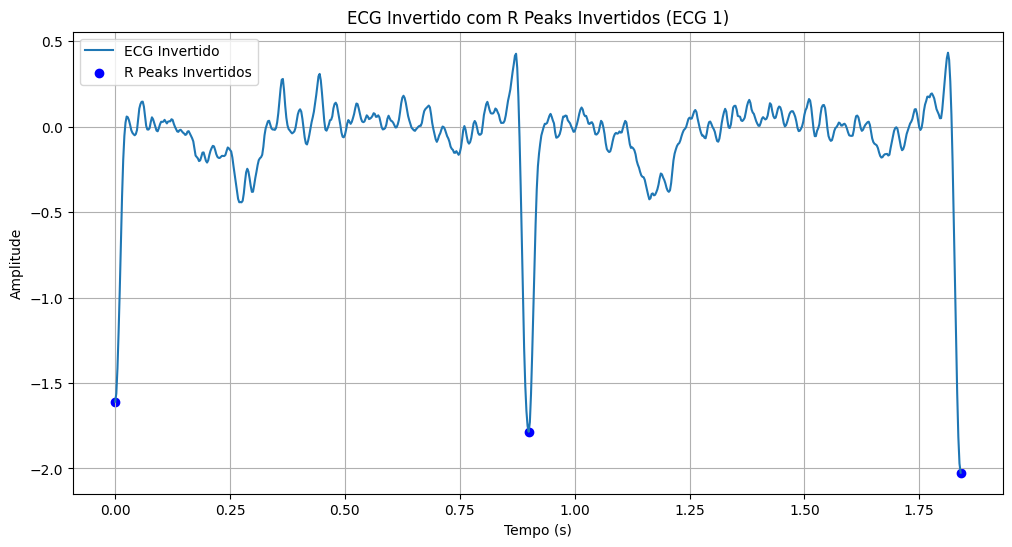

In [6]:
# Inverter os ECGs e os R peaks
invertido_ecgs, invertido_r_peaks_list = inverter_ecg_e_rpeaks(novo_ecg, r_peaks_list)

# Exemplo: Plotar o primeiro ECG invertido com seus R peaks invertidos
if len(invertido_ecgs) > 0 and len(invertido_r_peaks_list) > 0:
    ecg_index = 0  # Índice do ECG a ser plotado
    plotar_ecg_invertido_com_rpeaks(
        invertido_ecgs[ecg_index],
        invertido_r_peaks_list[ecg_index],
        sampling_rate=400,
        ecg_index=ecg_index
    )
else:
    print("Nenhum ECG invertido disponível para plotagem.")


Processando e plotando 1 ECGs.

--- Processando ECG 1 ---
Picos R originais: [  0 360 736]
Picos R ordenados: [0, 360, 736]
Excluindo de 0 até 60 (R1 + 150ms)
Excluindo de 392 até o fim do ECG (R2 + 80ms)
Total de índices ignorados: 405
Pontos selecionados por amplitude: [360, 359, 361, 358, 362, 357, 363, 356, 364, 355, 365, 354, 366, 110, 108, 109, 111, 107, 112, 119, 120, 106, 367, 118, 353, 121, 113, 105, 117, 122, 104, 114, 123, 116, 115, 368, 103, 124, 80, 73, 79, 74, 81, 125, 72, 126, 91, 90, 102, 127, 71, 89, 92, 78, 75, 95, 94, 93, 70, 82, 96, 299, 128, 88, 369, 298, 296, 295, 300, 76, 77, 101, 297, 97, 83, 100, 294, 87, 293, 69, 99, 84, 301, 98, 129, 292, 86, 85, 167, 308, 370, 166, 309, 280, 291, 307, 68, 168, 302, 281]
Calculating visibility relations...
Calculating visibility relations...
Grafo de visibilidade criado.
Ponto 360 tem visibilidade com 16 pontos.
Ponto 359 tem visibilidade com 15 pontos.
Ponto 361 tem visibilidade com 15 pontos.
Ponto 358 tem visibilidade com 

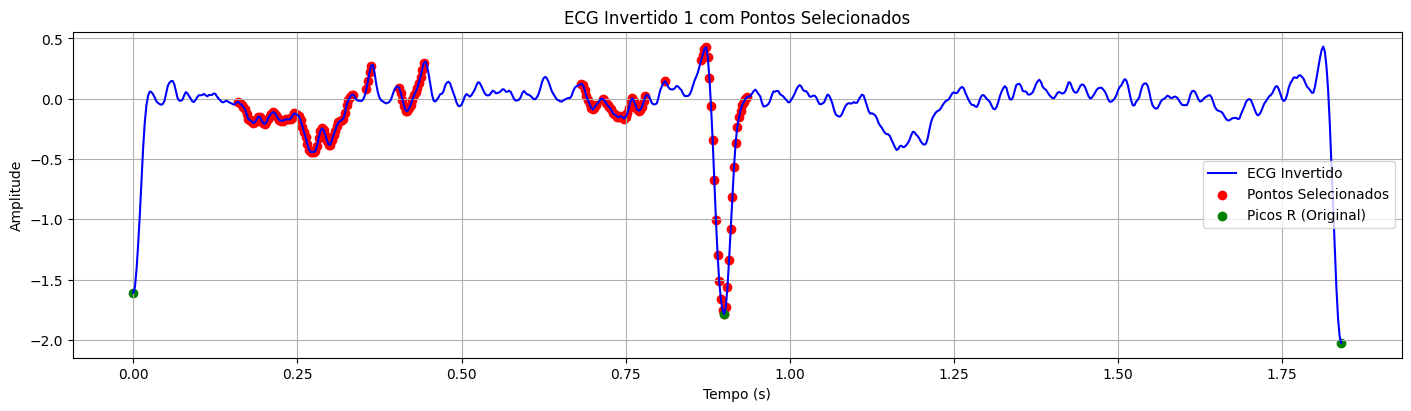

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pyunicorn.timeseries import VisibilityGraph
import networkx as nx  # Para identificar componentes conectado

# Parâmetros Globais
SAMPLING_RATE = 400  # Hz
TOP_N_POINTS = 100
EXCL_FIRST_MS = 150  # ms
EXCL_SECOND_MS = 80  # ms
N_ECGS_TO_PLOT = 1   # Número de ECGs a serem plotados

def segmentar_ecg(ecg, picos_r, sampling_rate, top_n, excl_first_ms, excl_second_ms):
    """
    Segmenta o ECG invertido excluindo regiões após os picos R.
    
    Parâmetros:
    - ecg: array 1D - Sinal de ECG invertido.
    - picos_r: list of int - Índices dos picos R.
    - sampling_rate: int - Taxa de amostragem (Hz).
    - top_n: int - Número de pontos de menor amplitude para análise de visibilidade.
    - excl_first_ms: int - Duração da exclusão após o primeiro pico R (ms).
    - excl_second_ms: int - Duração da exclusão após o segundo pico R (ms).
    
    Retorna:
    - pontos_selecionados: list of int - Índices dos pontos selecionados.
    """
    ignorar = np.zeros(len(ecg), dtype=bool)
    excl_first = int(excl_first_ms * sampling_rate / 1000)
    excl_second = int(excl_second_ms * sampling_rate / 1000)
    
    picos_r = sorted(picos_r)
    print(f"Picos R ordenados: {picos_r}")
    
    # Excluir após o primeiro pico R
    if len(picos_r) > 0:
        r1 = picos_r[0]
        end1 = min(r1 + excl_first, len(ecg))
        ignorar[r1:end1] = True
        print(f"Excluindo de {r1} até {end1} (R1 + {excl_first_ms}ms)")
    
    # Excluir do segundo pico R +40ms até o fim
    if len(picos_r) > 1:
        r2 = picos_r[1]
        start2 = r2 + excl_second
        if start2 < len(ecg):
            ignorar[start2:] = True
            print(f"Excluindo de {start2} até o fim do ECG (R2 + {excl_second_ms}ms)")
    
    # Debug: Mostrar os índices ignorados
    ignorados = np.where(ignorar)[0]
    print(f"Total de índices ignorados: {len(ignorados)}")
    
    # Selecionar top_n pontos de menor amplitude excluindo ignorados
    indices_amplitudes = np.argsort(ecg)  # Ordena por amplitude (mais negativo primeiro)
    selecionados = [idx for idx in indices_amplitudes if not ignorar[idx]][:top_n]
    print(f"Pontos selecionados por amplitude: {selecionados}")
    
    # Construir grafo de visibilidade
    VG = VisibilityGraph(ecg, horizontal=False)
    vis_relations = VG.visibility_relations()
    print("Grafo de visibilidade criado.")
    
    # Coletar pontos visíveis
    pontos_visiveis = set()
    for idx in selecionados:
        visiveis = np.where(vis_relations[idx, :])[0]
        pontos_visiveis.update(visiveis)
        print(f"Ponto {idx} tem visibilidade com {len(visiveis)} pontos.")
    
    # Filtrar pontos visíveis fora das regiões ignoradas
    pontos_selecionados = sorted([p for p in pontos_visiveis if not ignorar[p]])
    print(f"Pontos selecionados finais: {pontos_selecionados}")
    
    return pontos_selecionados

def plotar_ecg(ecg, t, pontos_selecionados, picos_r, ax, title):
    """
    Plota o ECG invertido com pontos selecionados e picos R.
    
    Parâmetros:
    - ecg: array 1D - Sinal de ECG invertido.
    - t: array 1D - Vetor de tempo correspondente.
    - pontos_selecionados: list of int - Índices dos pontos selecionados.
    - picos_r: list of int - Índices dos picos R.
    - ax: matplotlib.axes.Axes - Objeto de eixo para plotagem.
    - title: str - Título do gráfico.
    """
    ax.plot(t, ecg, label="ECG Invertido", color="blue")
    ax.scatter(t[pontos_selecionados], ecg[pontos_selecionados], 
               color="red", label="Pontos Selecionados")
    if len(picos_r) > 0:  # Modificação para evitar erro
        ax.scatter(t[picos_r], ecg[picos_r], 
                   color="green", label="Picos R (Original)")
    ax.set_xlabel("Tempo (s)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

def processar_e_plotar_ecgs(invertido_ecgs, invertido_r_peaks_list):
    """
    Processa e plota múltiplos ECGs invertidos.
    
    Parâmetros:
    - invertido_ecgs: list of arrays - Lista de ECGs invertidos (cada ECG pode ter múltiplas derivações).
    - invertido_r_peaks_list: list of lists - Lista contendo listas de picos R para cada ECG invertido.
    """
    n_ecgs = min(N_ECGS_TO_PLOT, len(invertido_ecgs), len(invertido_r_peaks_list))
    print(f"Processando e plotando {n_ecgs} ECGs.")
    
    fig, axs = plt.subplots(n_ecgs, 1, figsize=(14, 4 * n_ecgs), constrained_layout=True)
    if n_ecgs == 1:
        axs = [axs]
    
    for i in range(n_ecgs):
        ecg = invertido_ecgs[i][0]  # Primeira derivação
        t = np.arange(len(ecg)) / SAMPLING_RATE
        picos_r = invertido_r_peaks_list[i]
        
        print(f"\n--- Processando ECG {i + 1} ---")
        print(f"Picos R originais: {picos_r}")
        
        pontos_selecionados = segmentar_ecg(
            ecg, picos_r, SAMPLING_RATE, TOP_N_POINTS, EXCL_FIRST_MS, EXCL_SECOND_MS
        )
        
        plotar_ecg(ecg, t, pontos_selecionados, picos_r, 
                  axs[i], f"ECG Invertido {i+1} com Pontos Selecionados")
    
    plt.show()

# Exemplo de uso
# Supondo que 'invertido_ecgs' e 'invertido_r_peaks_list' já estejam definidos
# Vamos processar e plotar os primeiros três ECGs invertidos

processar_e_plotar_ecgs(
    invertido_ecgs=invertido_ecgs, 
    invertido_r_peaks_list=invertido_r_peaks_list
)


Processando e plotando 5 ECGs.

--- Processando ECG 1 ---
Picos R originais: [  0 360 736]
Picos R ordenados: [0, 360, 736]
Excluindo de 0 até 60 (R1 + 150ms)
Excluindo de 376 até o fim do ECG (R2 + 40ms)
Total de índices ignorados: 421
Pontos selecionados por amplitude: [360, 359, 361, 358, 362, 357, 363, 356, 364, 355, 365, 354, 366, 110, 108, 109, 111, 107, 112, 119, 120, 106, 367, 118, 353, 121, 113, 105, 117, 122, 104, 114, 123, 116, 115, 368, 103, 124, 80, 73, 79, 74, 81, 125, 72, 126, 91, 90, 102, 127, 71, 89, 92, 78, 75, 95, 94, 93, 70, 82, 96, 299, 128, 88, 369, 298, 296, 295, 300, 76, 77, 101, 297, 97, 83, 100, 294, 87, 293, 69, 99, 84, 301, 98, 129, 292, 86, 85, 167, 308, 370, 166, 309, 280, 291, 307, 68, 168, 302, 281, 279, 290, 67, 310, 165, 199, 352, 198, 289, 306, 66, 282, 371, 130, 169, 200, 61, 317, 318, 62, 278, 60, 65, 154, 319, 283, 316, 288, 155, 197, 153, 63, 156, 372, 64, 261, 184, 311, 152, 260, 303, 139, 201, 183, 305, 284, 138, 137, 233, 262]
Janela 0: de 60 a

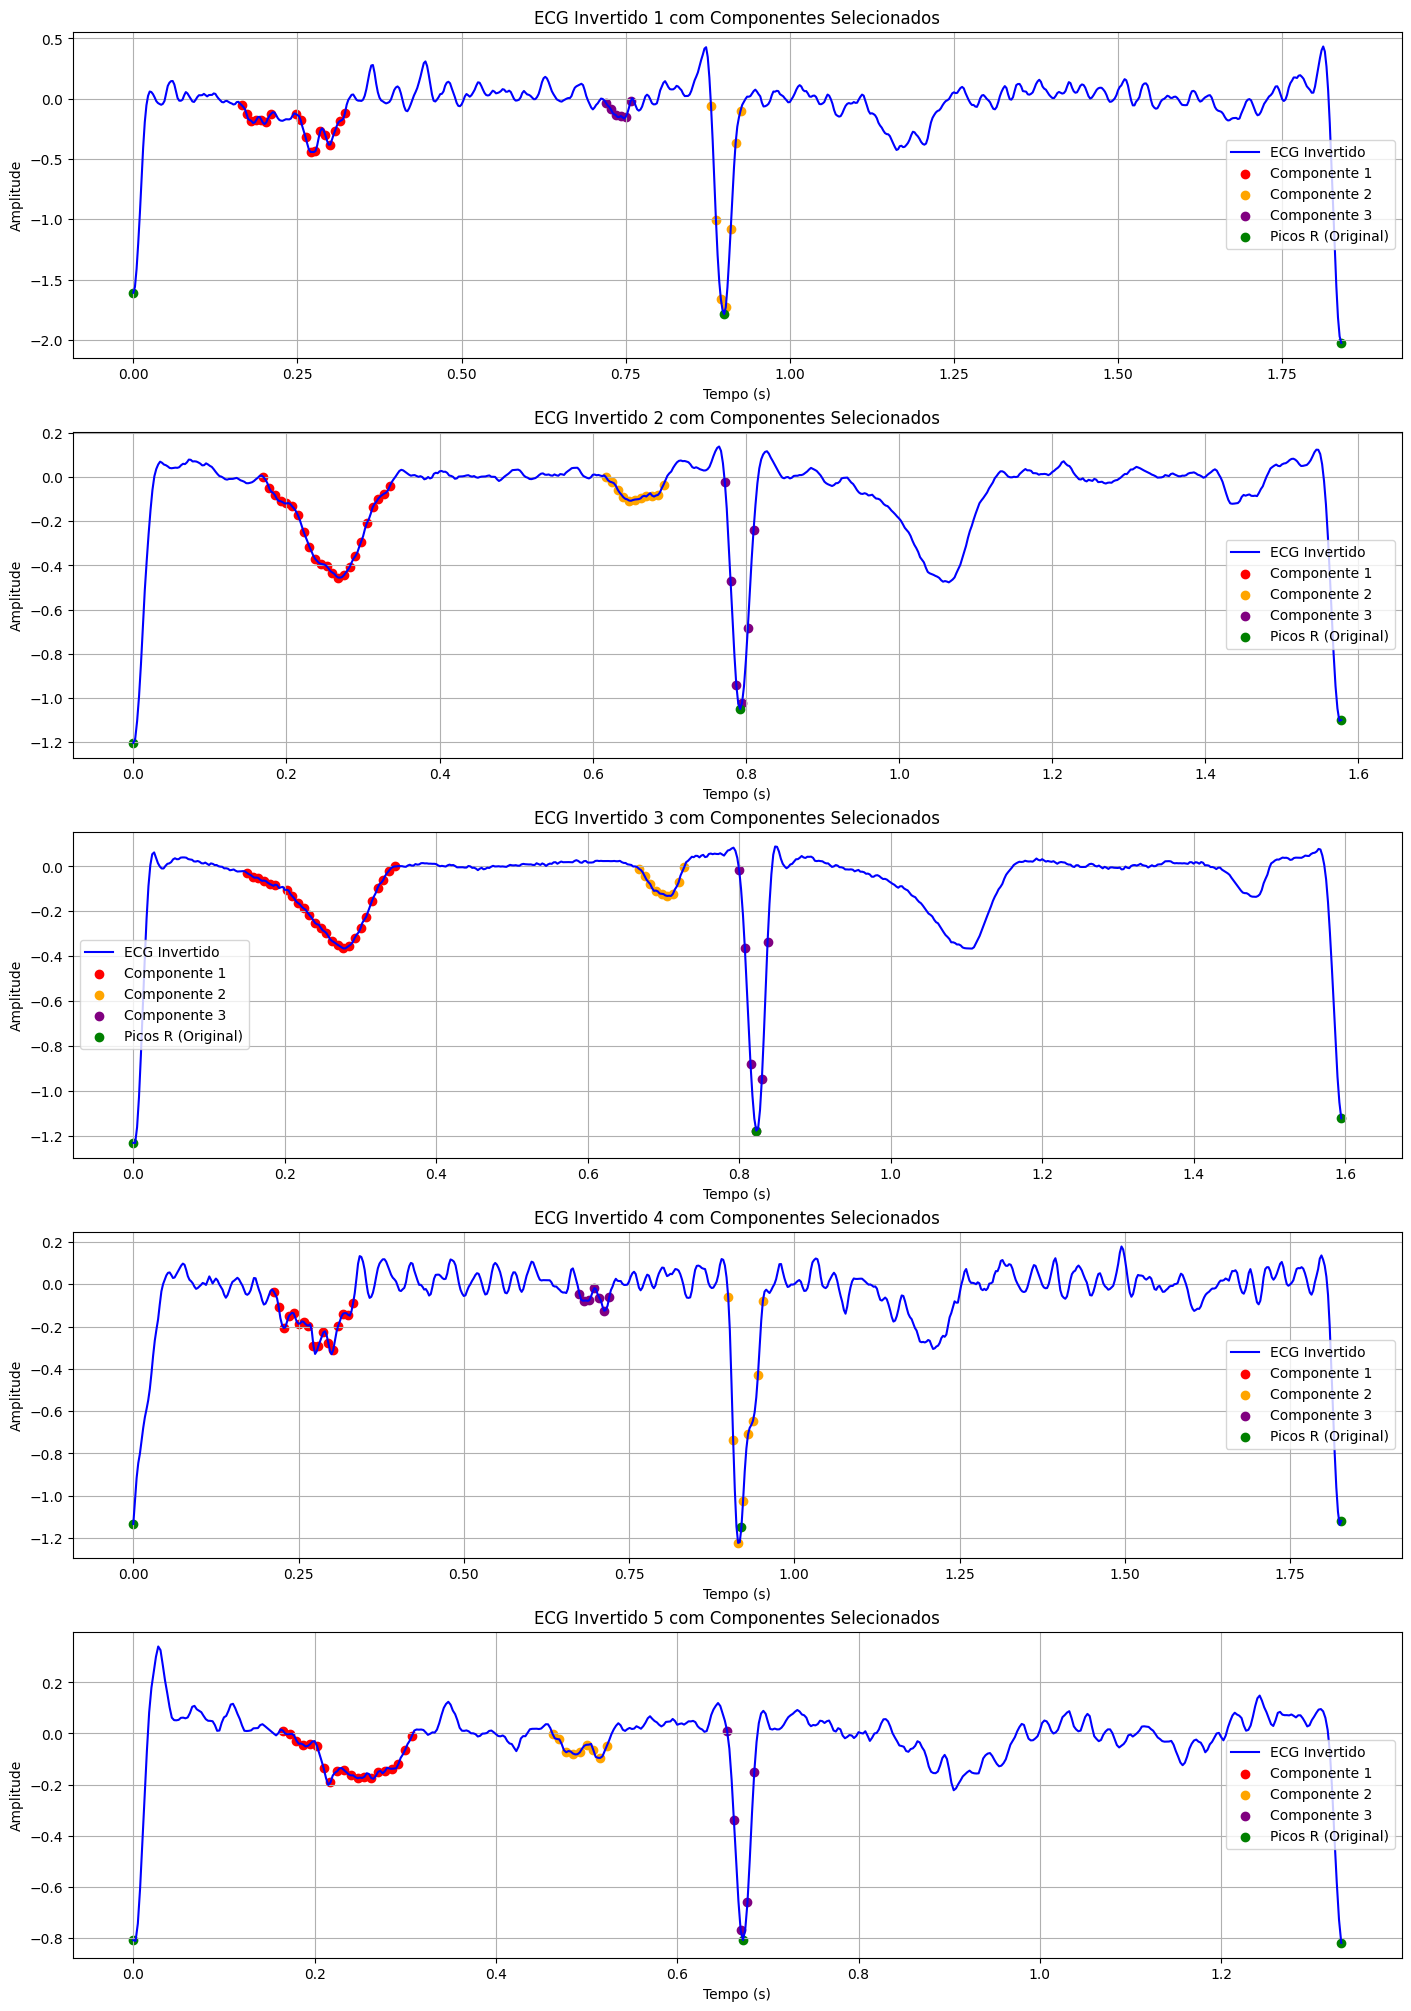

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from pyunicorn.timeseries import VisibilityGraph
import networkx as nx  # Para identificar componentes conectados

# --- Parâmetros Globais ---
SAMPLING_RATE = 400  # Hz
TOP_N_POINTS = 150
EXCL_FIRST_MS = 150  # ms
EXCL_SECOND_MS = 40   # ms
N_ECGS_TO_PLOT = 5    # Número de ECGs a serem plotados
WINDOW_SIZE_SEC = 3    # Tamanho da janela em segundos
WINDOW_STEP_SEC = 1    # Passo da janela em segundos
MIN_NODES_PER_WINDOW = 5
MIN_DISTANCE = 3       # Mínima distância entre nós (em amostras)

# --- Funções ---
def segmentar_ecg(ecg, picos_r, sampling_rate, top_n, excl_first_ms, excl_second_ms):
    ignorar = np.zeros(len(ecg), dtype=bool)
    excl_first = int(excl_first_ms * sampling_rate / 1000)
    excl_second = int(excl_second_ms * sampling_rate / 1000)
    
    picos_r = sorted(picos_r)
    print(f"Picos R ordenados: {picos_r}")
    
    # Excluir após o primeiro pico R
    if len(picos_r) > 0:
        r1 = picos_r[0]
        end1 = min(r1 + excl_first, len(ecg))
        ignorar[r1:end1] = True
        print(f"Excluindo de {r1} até {end1} (R1 + {excl_first_ms}ms)")
    
    # Excluir do segundo pico R +40ms até o fim
    if len(picos_r) > 1:
        r2 = picos_r[1]
        start2 = r2 + excl_second
        if start2 < len(ecg):
            ignorar[start2:] = True
            print(f"Excluindo de {start2} até o fim do ECG (R2 + {excl_second_ms}ms)")
    
    # Debug: Mostrar os índices ignorados
    ignorados = np.where(ignorar)[0]
    print(f"Total de índices ignorados: {len(ignorados)}")
    
    # Selecionar top_n pontos de menor amplitude excluindo ignorados
    indices_amplitudes = np.argsort(ecg)  # Ordena por amplitude (mais negativo primeiro)
    selecionados = [idx for idx in indices_amplitudes if not ignorar[idx]][:top_n]
    print(f"Pontos selecionados por amplitude: {selecionados}")
    
    return selecionados

def selecionar_pontos_com_janelas(pontos, window_size, window_step, min_nodes, min_distance):
    pontos = sorted(pontos)
    pontos_filtrados = []
    n = len(pontos)
    
    start = 0
    while start < n:
        window_start = pontos[start]
        window_end = window_start + window_size
        # Encontre pontos dentro da janela
        window_pontos = [p for p in pontos if window_start <= p < window_end]
        print(f"Janela {start}: de {window_start} até {window_end} com {len(window_pontos)} pontos")
        if len(window_pontos) >= min_nodes:
            # Selecionar pontos com distância mínima
            selecionados = []
            last_selected = -min_distance  # Inicializar para permitir a primeira seleção
            for p in window_pontos:
                if p - last_selected >= min_distance:
                    selecionados.append(p)
                    last_selected = p
            pontos_filtrados.extend(selecionados)
            print(f"Pontos selecionados na janela: {selecionados}")
        start += window_step
    
    # Remover duplicatas e ordenar
    pontos_filtrados = sorted(list(set(pontos_filtrados)))
    print(f"Pontos após aplicar janelas e distância mínima: {pontos_filtrados}")
    return pontos_filtrados

def encontrar_componentes_conectados(ecg, pontos_selecionados, visibility_relations, n_components=4):
    # Construir grafo
    G = nx.Graph()
    G.add_nodes_from(pontos_selecionados)
    
    # Adicionar arestas baseadas nas relações de visibilidade
    pontos_array = np.array(pontos_selecionados)
    for i, idx in enumerate(pontos_array):
        visiveis_relativos = np.where(visibility_relations[idx, pontos_array])[0]
        # Mapear índices relativos para absolutos
        visiveis_absolutos = pontos_array[visiveis_relativos]
        for j in visiveis_absolutos:
            if j != idx:
                G.add_edge(idx, j)
    
    # Encontrar componentes conectados
    componentes = list(nx.connected_components(G))
    # Ordenar componentes por tamanho (maiores primeiro)
    componentes_sorted = sorted(componentes, key=lambda x: len(x), reverse=True)
    # Selecionar os top_n_components
    principais_componentes = componentes_sorted[:n_components]
    
    # Converter conjuntos para listas ordenadas
    principais_componentes = [sorted(list(c)) for c in principais_componentes]
    
    return principais_componentes

def plotar_ecg_com_componentes(ecg, t, componentes, picos_r, ax, title):
    ax.plot(t, ecg, label="ECG Invertido", color="blue")
    colors = ['red', 'orange', 'purple', 'green', 'blue', 'yellow', 'pink', 'brown', 'gray']
    for i, componente in enumerate(componentes):
        if len(componente) == 0:
            continue
        ax.scatter(t[componente], ecg[componente], color=colors[i % len(colors)], 
                   label=f"Componente {i+1}")
    if len(picos_r) > 0:  # Correção para evitar erro
        ax.scatter(t[picos_r], ecg[picos_r], color="green", label="Picos R (Original)")
    ax.set_xlabel("Tempo (s)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

def processar_e_plotar_ecgs(invertido_ecgs, invertido_r_peaks_list):
    n_ecgs = min(N_ECGS_TO_PLOT, len(invertido_ecgs), len(invertido_r_peaks_list))
    print(f"Processando e plotando {n_ecgs} ECGs.")
    
    fig, axs = plt.subplots(n_ecgs, 1, figsize=(14, 4 * n_ecgs), constrained_layout=True)
    if n_ecgs == 1:
        axs = [axs]
    
    for i in range(n_ecgs):
        ecg = invertido_ecgs[i][0]  # Primeira derivação
        t = np.arange(len(ecg)) / SAMPLING_RATE
        picos_r = invertido_r_peaks_list[i]
        
        print(f"\n--- Processando ECG {i + 1} ---")
        print(f"Picos R originais: {picos_r}")
        
        # Segmentação inicial
        pontos_selecionados = segmentar_ecg(
            ecg, picos_r, SAMPLING_RATE, TOP_N_POINTS, EXCL_FIRST_MS, EXCL_SECOND_MS
        )
        
        # Aplicar restrições adicionais (janelas e distância)
        window_size = WINDOW_SIZE_SEC * SAMPLING_RATE   # Tamanho da janela em amostras
        window_step = WINDOW_STEP_SEC * SAMPLING_RATE   # Passo da janela em amostras
        pontos_filtrados = selecionar_pontos_com_janelas(
            pontos=pontos_selecionados, 
            window_size=window_size, 
            window_step=window_step, 
            min_nodes=MIN_NODES_PER_WINDOW, 
            min_distance=MIN_DISTANCE
        )
        
        print(f"Pontos após aplicar janelas e distância mínima: {pontos_filtrados}")
        
        if not pontos_filtrados:
            print("Nenhum ponto selecionado após aplicar as restrições.")
            continue
        
        # Construir grafo de visibilidade para os pontos filtrados
        VG = VisibilityGraph(ecg, horizontal=False)
        vis_relations = VG.visibility_relations()
        print("Grafo de visibilidade criado para pontos filtrados.")
        
        # Encontrar componentes conectados
        componentes = encontrar_componentes_conectados(
            ecg, pontos_filtrados, vis_relations, n_components=3
        )
        
        print(f"Componentes conectados: {componentes}")
        
        if not componentes:
            print("Nenhum componente conectado encontrado.")
            continue
        
        # Plotar
        plotar_ecg_com_componentes(
            ecg, t, componentes, picos_r, axs[i], 
            f"ECG Invertido {i+1} com Componentes Selecionados"
        )
    
    plt.show()


processar_e_plotar_ecgs(
    invertido_ecgs=invertido_ecgs, 
    invertido_r_peaks_list=invertido_r_peaks_list
)
